In [1]:
# — Standard library —
import textwrap

# — Data handling —
import numpy as np
import pandas as pd

# — Geospatial vector & stats —
import geopandas as gpd
from shapely.geometry import shape
from rasterstats import zonal_stats

# — Geospatial raster & reprojection —
import rasterio
from rasterio.crs import CRS
from rasterio.features import shapes
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.warp import transform_bounds
from rasterio.plot import show  

# — Mapping & interactive maps —
import folium
from branca.element import Figure

# — Plotting —
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from shapely.geometry import box



In [2]:
# Paths to  data
veg_path = "jotrgeodata.gpkg"
veg_layer = "JOTR_VegPolys"
raw_raster_path = "refined_rbr.tif"


In [4]:
# Load vegetation data
veg = gpd.read_file(veg_path, layer=veg_layer)

# check coordinates reference system 
print("Vegetation data", veg.crs)

with rasterio.open(raw_raster_path) as src:
    print(" Burn severity raster CRS:", src.crs)

Vegetation data EPSG:26911
 Burn severity raster CRS: EPSG:4326


## Explore interactive map of fire location

In [5]:

# Save PNG of fire severity raster for overlay 

overlay_png     = "rbr_overlay.png" 

# Read + mask out nodata
with rasterio.open(raw_raster_path) as src:
    data = src.read(1, masked=True)

# Compute a percentile stretch
valid = data.compressed()
vmin, vmax = np.percentile(valid, (2, 98))

# Build the transparent figure
fig, ax = plt.subplots(figsize=(8, 8), dpi=150)
fig.patch.set_facecolor("none")
ax.patch.set_facecolor("none")

# Plot with that stretch
show(
    data,
    transform=src.transform,
    ax=ax,
    cmap="Greys",           
    vmin=vmin,
    vmax=vmax,
    interpolation="nearest"
)
ax.set_axis_off()

# Save
plt.savefig(
    overlay_png,
    transparent=True,
    bbox_inches="tight",
    pad_inches=0
)
plt.close(fig)


# Interactive map with fire overlay


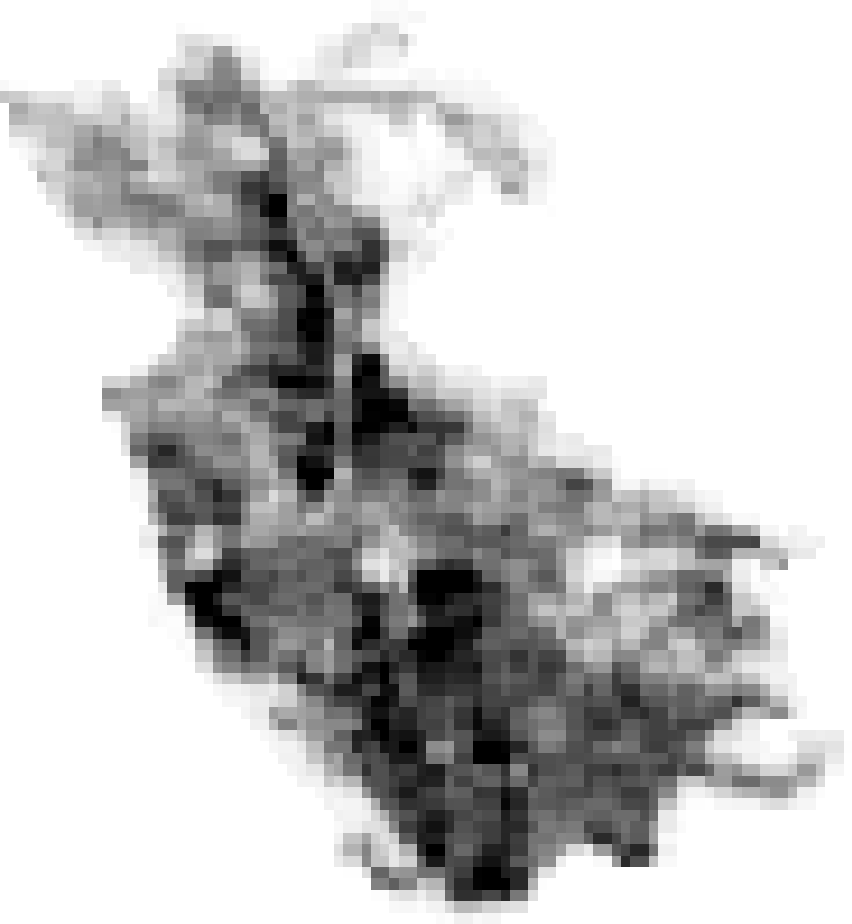

In [6]:

# 1) Read the raster bounds & CRS
with rasterio.open(raw_raster_path) as src:
    bnds   = src.bounds    # left, bottom, right, top
    src_crs = src.crs

# 2) Reproject bounds to WGS84 lat/lon
west, south, east, north = transform_bounds(
    src_crs, "EPSG:4326",
    bnds.left, bnds.bottom,
    bnds.right, bnds.top,
    densify_pts=21
)

# 3) Build img_bounds and center
img_bounds = [[south, west], [north, east]]
center     = [(south + north) / 2, (west + east) / 2]

# 4) Create fixed-size Figure + Folium map
fig = Figure(width="800px", height="500px")
m   = folium.Map(location=center, zoom_start=12, tiles="OpenStreetMap")
fig.add_child(m)

# 5) Add the PNG overlay
folium.raster_layers.ImageOverlay(
    name="Refined RBR",
    image=overlay_png,
    bounds=img_bounds,
    opacity=1.0,
    interactive=True,
    cross_origin=False,
    zindex=1
).add_to(m)

# 6) Add layer control and show
folium.LayerControl().add_to(m)
fig


## Reproject raster to match vegetation data and calculate area

For the purpose of this analysis, we reprojected the fire severity raster into NAD83 / UTM zone 11N to match the vegetation map, which may introduce some imprecision of sentinel 2 cells

In [7]:

# Reproject raster 

# Define input & output paths
src_path = "refined_rbr.tif"           # your original RBR
dst_path = "refined_rbr_26911.tif"     # the UTM-11N version
raster_path = dst_path  

# 1) Define target CRS (EPSG:26911 = NAD83 / UTM zone 11N)
target_crs = CRS.from_epsg(26911)

# 2) Open source, compute transform & new dims
with rasterio.open(src_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, target_crs, src.width, src.height, *src.bounds
    )
    # update metadata
    kwargs = src.meta.copy()
    kwargs.update({
        "crs": target_crs,
        "transform": transform,
        "width": width,
        "height": height
    })

    # 3) Reproject into the new file
    with rasterio.open(dst_path, "w", **kwargs) as dst:
        reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dst, 1),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=target_crs,
            resampling=Resampling.nearest
        )

print(f"Reprojected raster written to {dst_path}")

Reprojected raster written to refined_rbr_26911.tif


In [8]:
#check the reprojected raster
with rasterio.open(raster_path) as src:
    print("Reprojected raster CRS:", src.crs)

Reprojected raster CRS: EPSG:26911


## Visualize fire severity (Relative Burn Ratio, RBR)

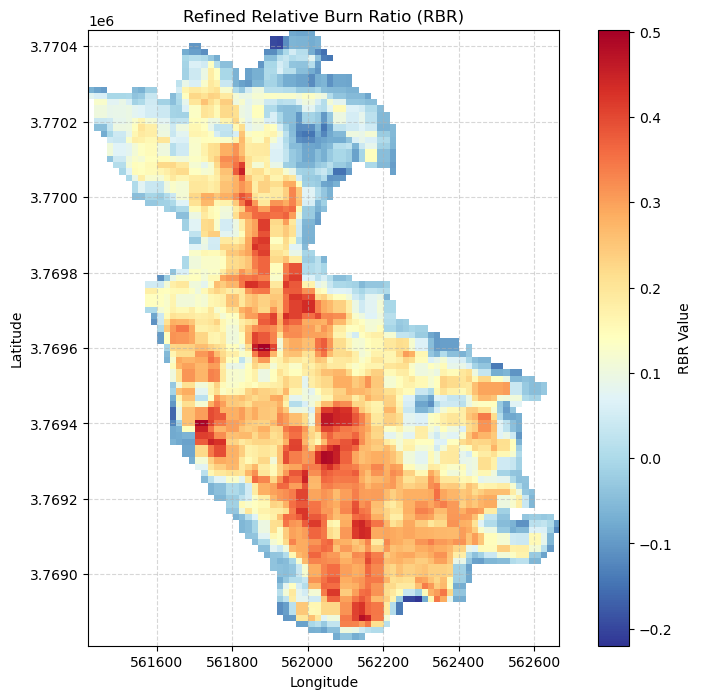

In [9]:
#Visualize fire severity

with rasterio.open(raster_path) as src:
    rbr = src.read(1)
    rbr[rbr == src.nodata] = np.nan
    bounds = src.bounds

# Plot with correct geographic extent
plt.figure(figsize=(10, 8))
plt.imshow(
    rbr,
    cmap="RdYlBu_r",
    extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
    origin="upper"
)
plt.colorbar(label="RBR Value")
plt.title("Refined Relative Burn Ratio (RBR)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


## Extract fire perimeter from raster

In [10]:
# Polygonize the raster to extract fire boundary
with rasterio.open(raster_path) as src:
    image = src.read(1)
    mask = image != src.nodata
    results = (
        {'properties': {'rbr': v}, 'geometry': s}
        for s, v in shapes(image, mask=mask, transform=src.transform)
        if v != 0
    )
    fire_polygons = gpd.GeoDataFrame.from_features(results, crs=src.crs)

In [11]:
# Merge into one polygon for fire boundary
fire_boundary = fire_polygons.union_all()  # use union_all, not unary_union
fire_boundary = gpd.GeoDataFrame(geometry=[fire_boundary], crs=fire_polygons.crs)

In [12]:
# export fire boundary to GeoPackage
fire_boundary.to_file("generated_fire_boundary_Eureka.gpkg", layer="fire_boundary", driver="GPKG")

## Explore vegetation types within fire perimeter

In [13]:
# Clip vegetation polygons to fire boundary
clipped = gpd.overlay(veg, fire_boundary, how="intersection")

#check coordinate reference system
print(clipped.crs)

#check columns
print(clipped.columns)


EPSG:26911
Index(['Poly_ID', 'MapUnit_ID', 'MapUnit_Name', 'X_Centroid', 'Y_Centroid',
       'Acres', 'Hectares', 'SHAPE_Length', 'SHAPE_Area', 'geometry'],
      dtype='object')


/opt/miniconda3/envs/geospatial/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


Calculate area of of each vegetation type within fire boundary

In [14]:
# Calculate area in hectares (1 ha = 10,000 m²)
clipped["area_ha"] = clipped.geometry.area / 10_000

# Group by vegetation type and calculate total hectares
summary = clipped.groupby("MapUnit_Name").agg(
    veg_ha=("area_ha", "sum")
).reset_index()

# Compute total fire area
total_fire_area = summary["veg_ha"].sum()

# Add percent of total area per vegetation type
summary["pct_of_total"] = 100 * summary["veg_ha"] / total_fire_area

# Add total row to summary
total_row = pd.DataFrame({
    "MapUnit_Name": ["Total Burned Area"],
    "veg_ha": [total_fire_area],
    "pct_of_total": [100.0]
})

# Combine with main summary
summary = pd.concat([summary, total_row], ignore_index=True)

# Export to CSV
summary.to_csv("veg_burned_summary.csv", index=False)

summary


,MapUnit_Name,veg_ha,pct_of_total
0,California Juniper / Blackbush Woodland Associ...,5.790077,5.603621
1,Joshua Tree - California Juniper / Nevada Ephe...,20.061632,19.415594
2,Joshua Tree / Blackbush Woodland Association,0.591952,0.572889
3,Mojave Yucca - Blackbush Shrubland Association,2.187525,2.117081
4,Muller Oak - California Buckwheat - Narrowleaf...,11.764780,11.385923
5,Red Brome - Mediterranean Grass Semi-Natural H...,5.619803,5.438830
6,Singleleaf Pinyon / Muller Oak Woodland Associ...,57.311649,55.466062
7,Total Burned Area,103.327418,100.000000


In [15]:
# Join summary back to polygons
clipped = clipped.merge(summary, on="MapUnit_Name", how="left")

Visualize vegetation types and their area (ha and percentage of total) within fire perimeter

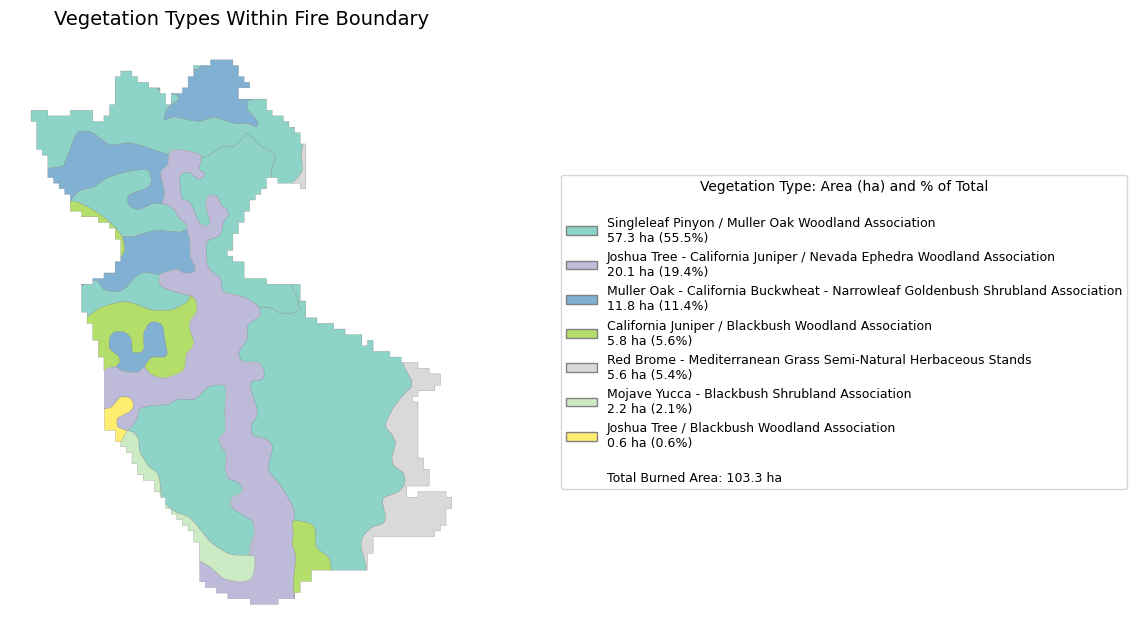

In [16]:
# Get summary of area by vegetation type
summary = clipped.groupby("MapUnit_Name").agg(
    area_ha=("area_ha", "sum")
).reset_index()
summary["pct_of_total"] = 100 * summary["area_ha"] / summary["area_ha"].sum()

# Sort by percent descending
summary = summary.sort_values(by="pct_of_total", ascending=False)
ordered_veg = summary["MapUnit_Name"].values

# Use updated colormap access (avoids deprecation warning)
base_cmap = plt.colormaps["Set3"]
color_list = base_cmap(np.linspace(0, 1, len(ordered_veg)))
colors = dict(zip(ordered_veg, color_list))

# Assign colors back to clipped
clipped["color"] = clipped["MapUnit_Name"].map(colors)

# Plot each vegetation type in order
fig, ax = plt.subplots(figsize=(10, 8))
for veg in ordered_veg:
    clipped[clipped["MapUnit_Name"] == veg].plot(
        ax=ax,
        color=colors[veg],
        edgecolor="gray",
        linewidth=0.2
    )

# Build legend entries
legend_patches = []
for veg in ordered_veg:
    row = summary[summary["MapUnit_Name"] == veg].iloc[0]
    label = f"{veg}\n{row['area_ha']:.1f} ha ({row['pct_of_total']:.1f}%)"
    patch = mpatches.Patch(facecolor=colors[veg], edgecolor='gray', label=label)
    legend_patches.append(patch)

# Add total burned area as final legend patch (invisible)
total_area = summary["area_ha"].sum()
total_label = f"\nTotal Burned Area: {total_area:.1f} ha"
total_patch = mpatches.Patch(facecolor='none', edgecolor='none', label=total_label)
legend_patches.append(total_patch)

# Add legend
ax.legend(
    handles=legend_patches,
    title="Vegetation Type: Area (ha) and % of Total\n",
    loc="center left",
    bbox_to_anchor=(1.15, 0.5),  # Move it further right to give more space
    fontsize=9,
    handlelength=2.5,            # Length of the color patch
    borderaxespad=1.5,           # Padding around legend content
    title_fontsize=10
)


ax.set_title("Vegetation Types Within Fire Boundary", fontsize=14, loc="center")
ax.axis("off")
plt.tight_layout()
plt.show()


## Fire severity by vegetation type

Summary statistic table

In [17]:
#Summary statistics of fire severity by vegetation type

# Define the exact order you want
ordered_veg = [
    "Singleleaf Pinyon / Muller Oak Woodland Association",
    "Joshua Tree - California Juniper / Nevada Ephedra Woodland Association",
    "Muller Oak - California Buckwheat - Narrowleaf Goldenbush Shrubland Association",
    "California Juniper / Blackbush Woodland Association",
    "Red Brome - Mediterranean Grass Semi-Natural Herbaceous Stands",
    "Mojave Yucca - Blackbush Shrubland Association",
    "Joshua Tree / Blackbush Woodland Association"
]

# 1) Compute zonal stats for each clipped vegetation polygon
stats = zonal_stats(
    clipped,
    raster_path,
    stats=["min", "max", "mean", "median", "std", "count"],
    nodata=np.nan
)

# 2) Build DataFrame and attach veg labels
df = pd.DataFrame(stats)
df["MapUnit_Name"] = clipped["MapUnit_Name"].values

# 3) Aggregate per vegetation type
summary = (
    df
    .groupby("MapUnit_Name")
    .agg(
        n_pixels   = ("count",  "sum"),
        min_RBR    = ("min",    "min"),
        max_RBR    = ("max",    "max"),
        mean_RBR   = ("mean",   "mean"),
        median_RBR = ("median", "mean"),
        sd_RBR     = ("std",    "mean")
    )
    .reset_index()
)

# 4) Re‐order the rows to match your violin order
summary = (
    summary
    .set_index("MapUnit_Name")
    .loc[ordered_veg]            # reindex in desired order
    .reset_index()
)

# 5) Display the ordered summary
print("Fire Severity Summary by Vegetation Type:")
display(summary)


Fire Severity Summary by Vegetation Type:


,MapUnit_Name,n_pixels,min_RBR,max_RBR,mean_RBR,median_RBR,sd_RBR
0,Singleleaf Pinyon / Muller Oak Woodland Associ...,2075,-0.196076,0.459427,0.148308,0.146518,0.104263
1,Joshua Tree - California Juniper / Nevada Ephe...,711,-0.163371,0.491433,0.261363,0.283515,0.119096
2,Muller Oak - California Buckwheat - Narrowleaf...,422,-0.201327,0.428921,0.132784,0.124412,0.083882
3,California Juniper / Blackbush Woodland Associ...,208,-0.219864,0.502264,0.113797,0.129897,0.094026
4,Red Brome - Mediterranean Grass Semi-Natural H...,203,-0.123796,0.274335,0.031413,0.003902,0.097575
5,Mojave Yucca - Blackbush Shrubland Association,82,-0.082166,0.418134,0.091542,0.064049,0.140413
6,Joshua Tree / Blackbush Woodland Association,22,-0.126338,0.491433,0.085180,-0.037145,0.185731


Plot fire severity by vegetation type

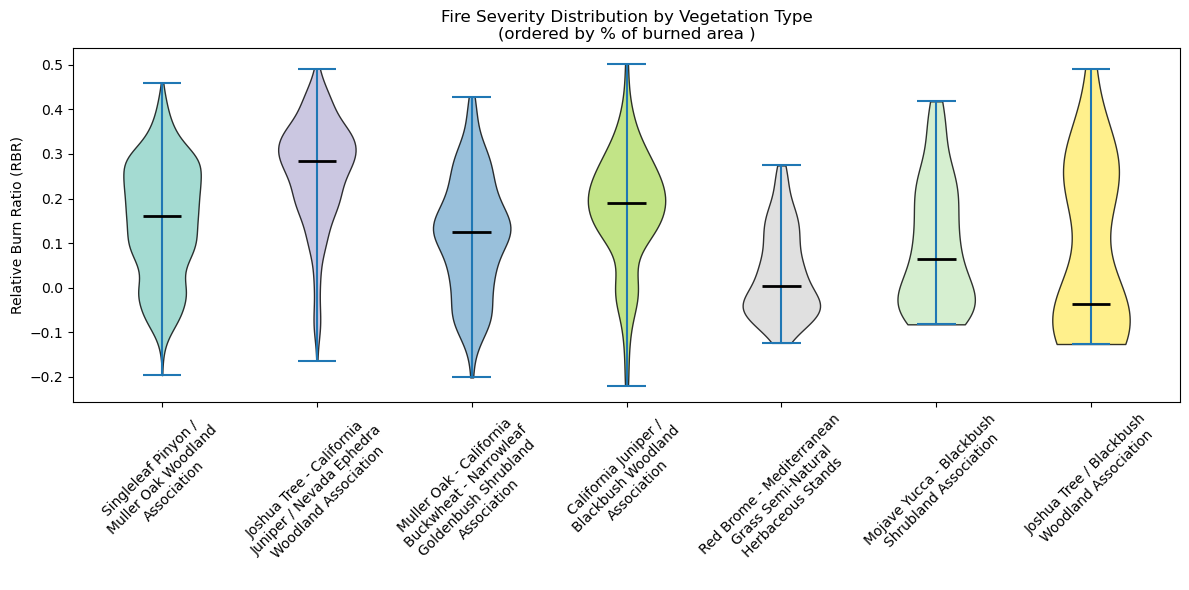

In [18]:
from rasterio.mask import mask as rio_mask   # alias it so there's no conflict


# — (Re)build the pixel_values list using rio_mask() —
pixel_values = []
with rasterio.open(raster_path) as src:
    nodata = src.nodata
    for veg in ordered_veg:
        geoms = clipped.loc[clipped["MapUnit_Name"] == veg, "geometry"]
        data, _ = rio_mask(src, geoms, crop=False)
        arr = data[0]
        pixel_values.append(arr[arr != nodata])

# — Prepare colors & labels —
cmap        = plt.colormaps["Set3"]
colors_list = cmap(np.linspace(0, 1, len(ordered_veg)))
labels      = [textwrap.fill(v, 25) for v in ordered_veg]

# — Plot side-by-side violins —
fig, ax = plt.subplots(figsize=(12, max(6, len(ordered_veg)*0.5)))
positions = np.arange(1, len(ordered_veg)+1)
parts = ax.violinplot(pixel_values, positions, showmedians=True)

for i, body in enumerate(parts["bodies"]):
    body.set_facecolor(colors_list[i])
    body.set_edgecolor("black")
    body.set_alpha(0.8)

parts["cmedians"].set_color("black")
parts["cmedians"].set_linewidth(2)

ax.set_xticks(positions)
ax.set_xticklabels(labels, rotation=45, ha="center", fontsize=10)
ax.set_ylabel("Relative Burn Ratio (RBR)")
ax.set_title("Fire Severity Distribution by Vegetation Type\n(ordered by % of burned area )")

plt.tight_layout()
plt.show()


## Fire history 

In [19]:
#Load the full fire history layer

fire_hist = gpd.read_file("HistFires_JOTR_MOJA/FindExistingLocationsOutput.shp")
fire_hist = fire_hist.to_crs("EPSG:26911")

In [20]:
#Check coordinate systems
print(fire_hist.crs)
print(fire_boundary.crs)

EPSG:26911
PROJCS["NAD83 / UTM zone 11N",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","26911"]]


Plot current fire and historical fires to identify overlaps

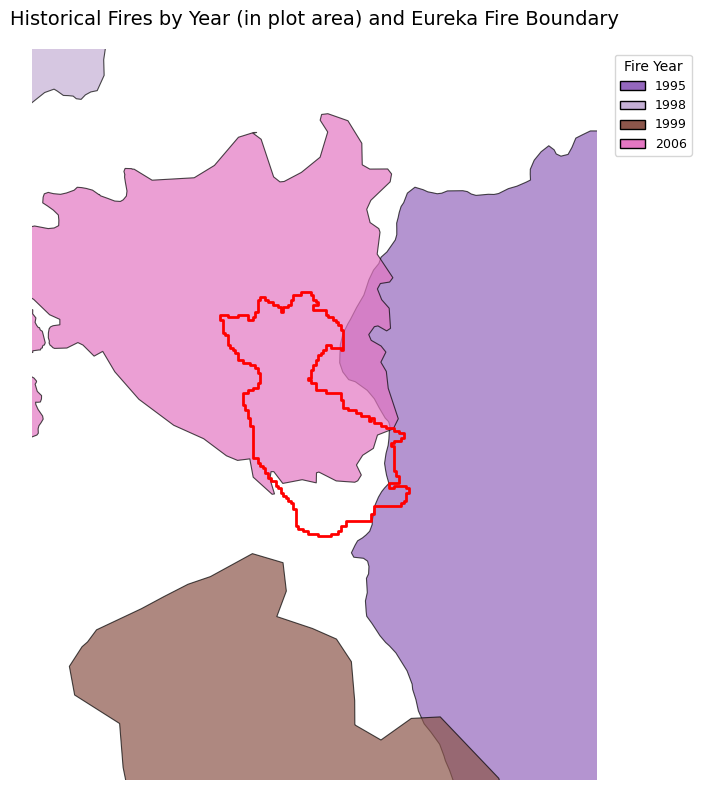

In [21]:
# Prepare sorted list of all years & their colors
all_years = sorted(fire_hist["YEAR_"].unique())
cmap      = plt.colormaps["tab20"]
palette   = cmap(np.linspace(0, 1, len(all_years)))
color_map = dict(zip(all_years, palette))

# Compute 100% buffer around the current boundary
minx, miny, maxx, maxy = fire_boundary.total_bounds
dx, dy   = maxx - minx, maxy - miny
buffer   = 1.0
view_bounds = box(
    minx - dx*buffer,
    miny - dy*buffer,
    maxx + dx*buffer,
    maxy + dy*buffer
)

# Find which fires intersect that buffered box
visible      = fire_hist[fire_hist.geometry.intersects(view_bounds)]
visible_years = sorted(visible["YEAR_"].unique())

# Plot all historic fires (only visible ones show up)
fig, ax = plt.subplots(figsize=(10, 8))
for yr in all_years:
    fire_hist[fire_hist["YEAR_"] == yr].plot(
        ax=ax,
        facecolor=color_map[yr],
        edgecolor="black",
        linewidth=0.8,
        alpha=0.7
    )

#  Draw the Eureka fire boundary in red
fire_boundary.plot(
    ax=ax,
    edgecolor="red",
    facecolor="none",
    linewidth=2
)

# Zoom to the buffered view
ax.set_xlim(minx - dx*buffer, maxx + dx*buffer)
ax.set_ylim(miny - dy*buffer, maxy + dy*buffer)

#  Legend only for visible years
handles = [
    mpatches.Patch(facecolor=color_map[yr], edgecolor="black", label=str(yr))
    for yr in visible_years
]
ax.legend(
    handles=handles,
    title="Fire Year",
    loc="upper left",
    bbox_to_anchor=(1.02, 1),
    fontsize=9
)

ax.set_title(
    "Historical Fires by Year (in plot area) and Eureka Fire Boundary",
    fontsize=14
)
ax.axis("off")
plt.tight_layout()
plt.show()


In [22]:
#Spatial filter: which historical fires intersect the current fire boundary?
overlapping_fires = gpd.overlay(fire_hist, fire_boundary, how='intersection')
overlapping_fires[["FIRE_NAME", "YEAR_"]].drop_duplicates()

/opt/miniconda3/envs/geospatial/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


,FIRE_NAME,YEAR_
0,WHISPERING PINES,2006
1,COVINGTON,1995


In [22]:
# Pull out the two historical fire polygons
whispering = fire_hist[fire_hist["FIRE_NAME"] == "WHISPERING PINES"]
covington  = fire_hist[fire_hist["FIRE_NAME"] == "COVINGTON"]


# Burn severity by fire history 

In [23]:

# —— 1) Compute stats & summary for the clipped historical fires ——
hist_stats = zonal_stats(
    overlapping_fires,
    raster_path,
    stats=["min","max","mean","std"],
    nodata=np.nan,
    geojson_out=True
)
hist_gdf = gpd.GeoDataFrame.from_features(hist_stats, crs=overlapping_fires.crs)
hist_gdf["FIRE_NAME"] = overlapping_fires["FIRE_NAME"].values
hist_gdf["YEAR_"]     = overlapping_fires["YEAR_"].values

fire_history_summary = (
    hist_gdf
    .groupby(["YEAR_","FIRE_NAME"])
    .agg(
        min_RBR  = ("min",  "min"),
        max_RBR  = ("max",  "max"),
        mean_RBR = ("mean", "mean"),
        sd_RBR   = ("std",  "mean"),
        area_ha  = ("geometry", lambda g: g.area.sum() / 10000)
    )
    .reset_index()
)

# —— 2) Build the “Unburned” summary exactly the same way ——
burned_union   = overlapping_fires.geometry.union_all()
boundary_union = fire_boundary.geometry.union_all()
unburned_poly  = boundary_union.difference(burned_union)
unburned_gdf   = gpd.GeoDataFrame({"geometry":[unburned_poly]}, crs=fire_boundary.crs)

ub_stats = zonal_stats(
    unburned_gdf,
    raster_path,
    stats=["min","max","mean","std"],
    nodata=np.nan,
    geojson_out=True
)
ub_gdf = gpd.GeoDataFrame.from_features(ub_stats)
ub_gdf["FIRE_NAME"] = "Unburned"
ub_gdf["YEAR_"]     = 0

unburned_summary = (
    ub_gdf
    .groupby(["YEAR_","FIRE_NAME"])
    .agg(
        min_RBR  = ("min",  "min"),
        max_RBR  = ("max",  "max"),
        mean_RBR = ("mean", "mean"),
        sd_RBR   = ("std",  "mean"),
        area_ha  = ("geometry", lambda g: g.area.sum() / 10000)
    )
    .reset_index()
)

# —— 3) Now you can safely stitch them together ——
full_fire_history = pd.concat(
    [fire_history_summary, unburned_summary],
    ignore_index=True
)

print("Burn Severity by Fire History (incl. Unburned)")
display(full_fire_history)

Burn Severity by Fire History (incl. Unburned)


,YEAR_,FIRE_NAME,min_RBR,max_RBR,mean_RBR,sd_RBR,area_ha
0,1995,COVINGTON,-0.123796,0.261695,0.027619,0.089724,4.586149
1,2006,WHISPERING PINES,-0.201327,0.502264,0.155107,0.136093,75.543807
2,0,Unburned,-0.219864,0.474377,0.209373,0.132453,23.377412


# Burn severity by Vegetation x Fire history 

In [24]:

# — 1) Build veg_history_summary (burned veg × fire) —
veg_hist = gpd.overlay(
    clipped[["MapUnit_Name","geometry"]],
    overlapping_fires[["FIRE_NAME","YEAR_","geometry"]],
    how="intersection"
)
vh_stats = zonal_stats(
    veg_hist,
    raster_path,
    stats=["min","max","mean","std"],
    nodata=np.nan,
    geojson_out=True
)
vh_gdf = gpd.GeoDataFrame.from_features(vh_stats, crs=clipped.crs)
vh_gdf["MapUnit_Name"] = veg_hist["MapUnit_Name"].values
vh_gdf["FIRE_NAME"]    = veg_hist["FIRE_NAME"].values
vh_gdf["YEAR_"]        = veg_hist["YEAR_"].values

veg_history_summary = (
    vh_gdf
    .groupby(["MapUnit_Name","FIRE_NAME","YEAR_"])
    .agg(
        min_RBR  = ("min",  "min"),
        max_RBR  = ("max",  "max"),
        mean_RBR = ("mean", "mean"),
        sd_RBR   = ("std",  "mean"),
        area_ha  = ("geometry", lambda g: g.area.sum() / 10000)
    )
    .reset_index()
)

# — 2) Build veg_unburned_summary (never-burned veg) —
# union of all burned polygons
burned_union = overlapping_fires.geometry.union_all()
veg_unburned = clipped.copy()
veg_unburned["geometry"] = veg_unburned.geometry.map(lambda g: g.difference(burned_union))
veg_unburned = veg_unburned[~veg_unburned.geometry.is_empty]

ub_stats = zonal_stats(
    veg_unburned,
    raster_path,
    stats=["min","max","mean","std"],
    nodata=np.nan,
    geojson_out=True
)
ub_gdf = gpd.GeoDataFrame.from_features(ub_stats, crs=clipped.crs)
ub_gdf["MapUnit_Name"] = veg_unburned["MapUnit_Name"].values
ub_gdf["FIRE_NAME"]    = "Previously Unburned"
ub_gdf["YEAR_"]        = 0

veg_unburned_summary = (
    ub_gdf
    .groupby(["MapUnit_Name","FIRE_NAME","YEAR_"])
    .agg(
        min_RBR  = ("min",  "min"),
        max_RBR  = ("max",  "max"),
        mean_RBR = ("mean", "mean"),
        sd_RBR   = ("std",  "mean"),
        area_ha  = ("geometry", lambda g: g.area.sum() / 10000)
    )
    .reset_index()
)

# — 3) Concatenate into full_veg_hist —
full_veg_hist = pd.concat(
    [veg_history_summary, veg_unburned_summary],
    ignore_index=True
)

ordered_fire  = ["COVINGTON", "WHISPERING PINES", "Previously Unburned"]

# — 5) Cast to ordered Categoricals & sort —
full_veg_hist["MapUnit_Name"] = pd.Categorical(
    full_veg_hist["MapUnit_Name"],
    categories=ordered_veg, ordered=True
)
full_veg_hist["FIRE_NAME"] = pd.Categorical(
    full_veg_hist["FIRE_NAME"],
    categories=ordered_fire, ordered=True
)

full_veg_hist = (
    full_veg_hist
    .sort_values(["MapUnit_Name", "FIRE_NAME"])
    .reset_index(drop=True)
)

# — 6) Display —
print(" Burn Severity by Vegetation × Fire History")
display(full_veg_hist)


 Burn Severity by Vegetation × Fire History


,MapUnit_Name,FIRE_NAME,YEAR_,min_RBR,max_RBR,mean_RBR,sd_RBR,area_ha
0,Singleleaf Pinyon / Muller Oak Woodland Associ...,COVINGTON,1995,0.036931,0.151126,0.083066,0.048671,0.073576
1,Singleleaf Pinyon / Muller Oak Woodland Associ...,WHISPERING PINES,2006,-0.196076,0.459427,0.146402,0.099279,43.929009
2,Singleleaf Pinyon / Muller Oak Woodland Associ...,Previously Unburned,0,-0.080014,0.422675,0.218790,0.114732,13.312362
3,Joshua Tree - California Juniper / Nevada Ephe...,WHISPERING PINES,2006,-0.163371,0.491433,0.262901,0.108962,14.166624
4,Joshua Tree - California Juniper / Nevada Ephe...,Previously Unburned,0,-0.113773,0.474377,0.257718,0.140148,5.896823
5,Muller Oak - California Buckwheat - Narrowleaf...,WHISPERING PINES,2006,-0.201327,0.428921,0.133075,0.083634,11.759396
6,California Juniper / Blackbush Woodland Associ...,WHISPERING PINES,2006,-0.108372,0.502264,0.093370,0.070862,4.410993
7,California Juniper / Blackbush Woodland Associ...,Previously Unburned,0,-0.219864,0.304877,0.152083,0.142639,1.380970
8,Red Brome - Mediterranean Grass Semi-Natural H...,COVINGTON,1995,-0.123796,0.261695,0.026232,0.090076,4.512573
9,Red Brome - Mediterranean Grass Semi-Natural H...,WHISPERING PINES,2006,-0.104842,-0.054172,-0.073517,0.018151,0.255332


# Plot Vegetation × Fire History

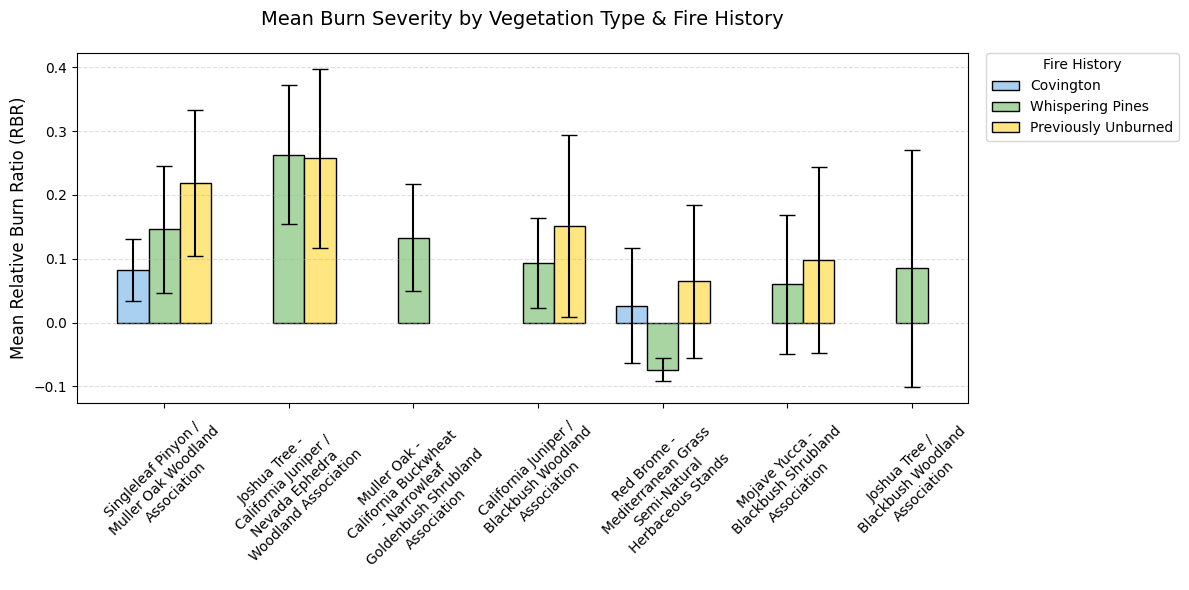

In [25]:


# — Pivot & rename Unburned → Previously Unburned —
mean_piv = full_veg_hist.pivot(
    index="MapUnit_Name", columns="FIRE_NAME", values="mean_RBR"
).rename(columns={"Unburned": "Previously Unburned"})
std_piv = full_veg_hist.pivot(
    index="MapUnit_Name", columns="FIRE_NAME", values="sd_RBR"
).rename(columns={"Unburned": "Previously Unburned"})

# Enforce your category order
cats     = ["COVINGTON", "WHISPERING PINES", "Previously Unburned"]
mean_piv = mean_piv[cats]
std_piv  = std_piv[cats]

# Reindex to your custom vegetation order
mean_piv = mean_piv.reindex(ordered_veg)
std_piv  = std_piv.reindex(ordered_veg)

x         = np.arange(len(ordered_veg))
width     = 0.25
colors    = ["#A9CFF1", "#A8D5A2", "#FFE680"]  # blue, green, amber

fig, ax = plt.subplots(figsize=(12,6))

for i, cat in enumerate(cats):
    ax.bar(
        x + (i - 1)*width,
        mean_piv[cat],
        width,
        yerr=std_piv[cat],
        capsize=6,
        linewidth=1,
        edgecolor="k",
        color=colors[i],
        label=cat.title()
    )

# Wrap & center the labels
wrapped = [textwrap.fill(lbl, 20) for lbl in ordered_veg]
ax.set_xticks(x)
ax.set_xticklabels(wrapped, rotation=45, ha="center", fontsize=10)

# Styling
ax.set_ylabel("Mean Relative Burn Ratio (RBR)", fontsize=12)
ax.set_title("Mean Burn Severity by Vegetation Type & Fire History", pad=20, fontsize=14)
ax.grid(axis="y", linestyle="--", alpha=0.4)

# Legend outside
ax.legend(
    title="Fire History",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0
)

plt.tight_layout()
plt.show()
